In [1]:
import sys 
sys.path.append('..')
import cox
from cox.utils import Parameters
import numpy as np
import pandas as pd
import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import IntervalUnion

# Experiment Set Up
Syntheize data, then truncate based off of a union of interval membership oracle.

In [30]:
# number of samples to sample from the uniform distribution
num_samples, dims = 5000, 2

# regression parameters
noise_var = Tensor([5.0])
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)
X = Uniform(ch.full((dims,), -5.0), ch.full((dims,), 5.0)).sample(ch.Size([num_samples]))

# synthesize data
y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(noise_var)).sample(ch.Size([num_samples]))
# initialize membership oracle
phi = IntervalUnion([(Tensor([-1.0]), Tensor([-.5])), (Tensor([0.0]), Tensor([0.5])), (Tensor([2.0]), Tensor([3.0]))])
# truncate
indices = phi(y).nonzero(as_tuple=False).flatten()
y_trunc, x_trunc = y[indices], X[indices]

# experiment parameters
args = Parameters({ 
    'alpha': Tensor([y_trunc.size(0)/num_samples]), 
    'phi': phi, 
    'epochs': 50,
    'num_workers': 1, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 2.0, 
    'var_lr': 1e-1,
    'lr': 1e-1,
})

# intialize dataset  
data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
S = DataLoader(data, batch_size=args.batch_size, shuffle=True)

print("Emprical Noise Variance: \n{}".format(data.lambda_.inverse()))
print("Empirical Weights: \n{}".format(data.lambda_.inverse()*data.v))
print("Empirical Bias: \n{}".format(data.lambda_.inverse()*data.v0))

Emprical Noise Variance: 
tensor([[1.5651]])
Empirical Weights: 
tensor([[0.3312],
        [0.3065]])
Empirical Bias: 
tensor([[0.9931]])


# Run Procedure

In [31]:
trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr)
results = trunc_reg.fit(S)

Epoch:1 | Loss 1.0884 | Train1 0.045 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 44.71it/s]
Epoch:2 | Loss 2.3451 | Train1 0.086 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 45.83it/s]
Epoch:3 | Loss 1.2681 | Train1 0.069 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 33.70it/s]
Epoch:4 | Loss 0.8783 | Train1 0.024 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 47.13it/s]
Epoch:5 | Loss 1.2728 | Train1 0.071 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 47.19it/s]
Epoch:6 | Loss 2.2007 | Train1 0.064 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 47.36it/s]
Epoch:7 | Loss 1.7551 | Train1 0.075 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 47.25it/s]
Epoch:8 | Loss 1.1599 | Train1 0.051 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 47.21it/s]
Epoch:9 | Loss 1.2805 | Train1 0.068 | Train5 -1

In [32]:
print("Predicted Noise Variance: \n{}".format(results.lambda_.inverse()))
print("Predicted Weights: \n{}".format(results.lambda_.inverse()*results.v))
print("Predicted Bias: \n{}".format(results.lambda_.inverse()*results.bias))

Predicted Noise Variance: 
tensor([[3.5106]], grad_fn=<InverseBackward>)
Predicted Weights: 
tensor([[0.6185],
        [1.0363]], grad_fn=<MulBackward0>)
Predicted Bias: 
tensor([[0.4973]], grad_fn=<MulBackward0>)


# Plot 1 Dimensional Figure

ValueError: x and y must be the same size

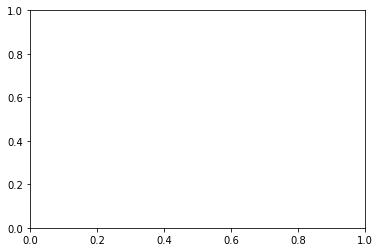

In [5]:
data = np.linspace(-3.0, 2.0, 1000)
results.to('cpu')

plt.scatter(x_trunc, y_trunc, color="grey", alpha=.25)
with ch.no_grad():
    plt.plot(data, results(ch.from_numpy(np.expand_dims(data, 1)).float()), color="green", label="predicted")
    plt.plot(data, S.dataset.reg.predict(np.expand_dims(data, 1)), color="red", label="empirical")
    plt.plot(data, ch.from_numpy(np.expand_dims(data, 1)).float().mm(W) + W0, color="blue", label="actual")
plt.legend() 

plt.xlabel("x")
plt.ylabel("y")

# Plot 2 Dimensional Figure

Text(0.5, 0, 'Y')

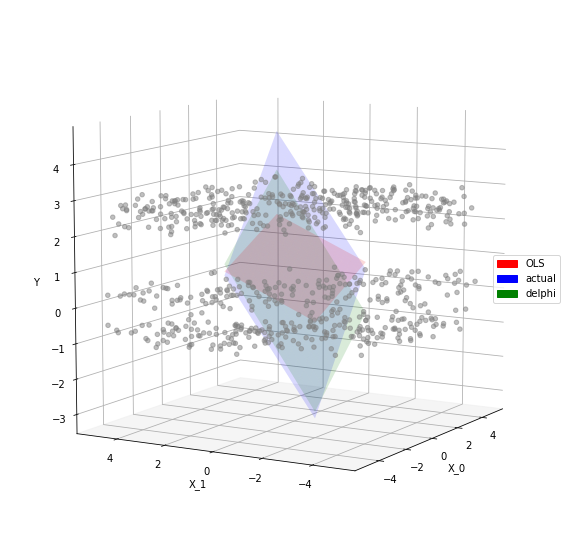

In [33]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="grey", alpha=.5)
with ch.no_grad():
    X = np.arange(-2, 2, 0.25)
    Y = np.arange(-2, 2, 0.25)
    X, Y = np.meshgrid(X, Y)

    # plot predicted regression
    pred = Tensor([results(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float()).numpy().flatten() for i in range(X.shape[0])]).numpy()
    ax.plot_surface(X, Y, pred, color="green", alpha=.15)
    
    # plot empirical regression - obtained via OLS
    emp = np.array([S.dataset.reg.predict(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).flatten() for i in range(X.shape[0])])
    ax.plot_surface(X, Y, emp, color="red", alpha=.15)
    
    # plot actual regression - based off of synthetic data
    act = ch.cat([(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float().mm(W) + W0) for i in range(X.shape[0])], 1).numpy()
    ax.plot_surface(X, Y, act, color="blue", alpha=.15)
    


red_patch = mpatches.Patch(color='red', label='OLS')

green_patch = mpatches.Patch(color='green', label='delphi')
blue_patch = mpatches.Patch(color='blue', label="actual")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="center right")

ax.view_init(10, -150)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

In [87]:
act.size()

torch.Size([16, 16])